## Import Libraries

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
np.random.seed(0)

## Helping Functions

In [31]:
def calcPSNR(image, source):
    L = np.max(image)
    R = L ** 2 / (1 / (image.shape[0] * image.shape[1]) * np.sum((image - source) ** 2))
    return float(10 * np.log10(R))

def load_image(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if np.max(img_gray) > 1:
        img_gray = img_gray / 255
    return img_gray

def add_gaussian_noise(image, std):
    noise = np.random.normal(scale=std, size=image.shape)
    noisy_img = image + noise
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 1] = 1
    return noisy_img, noise

def show_with_diff(image, noisy_image, noise_denoised, isnoise=False):
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=1, interpolation="nearest")
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=1, interpolation="nearest")
    plt.title('PSNR = ' + str(round(calcPSNR(noisy_image, image), 4)))
    plt.subplot(1, 3, 3)
    if isnoise:
        plt.imshow(noise_denoised, cmap=plt.cm.PuOr, vmin=-0.5, vmax=0.5, interpolation="nearest")
    else:
        plt.imshow(noise_denoised, cmap='gray', vmin=0, vmax=1, interpolation="nearest")
        plt.title('PSNR = ' + str(round(calcPSNR(noise_denoised, image), 4)))
    plt.show()

def extract_patches(image, patch_size):
    dataset = extract_patches_2d(image, patch_size)
    dataset = dataset.reshape(-1, patch_size[0] * patch_size[1])
    dataset -= np.mean(dataset, axis=0)
    dataset /= np.std(dataset, axis=0)
    return dataset

## Load Image and Add Gassian Noise

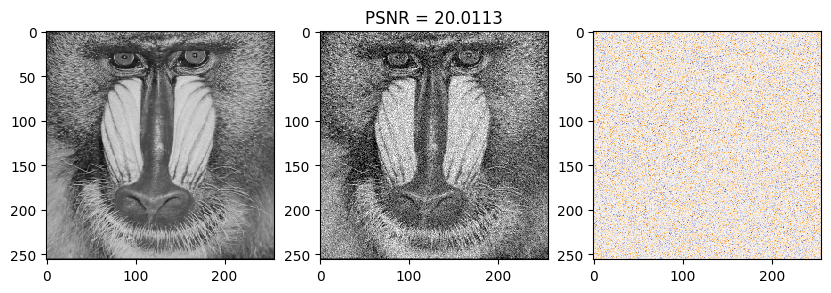

In [32]:
image = load_image('mandrill.jpg')
width, height = image.shape
image = cv2.resize(image, (int(width / 2), int(height / 2)), interpolation = cv2.INTER_AREA)
width, height = image.shape

sigma = 0.1
noisy_image, noise = add_gaussian_noise(image, sigma)

show_with_diff(image, noisy_image, noise, True)

## Extract Patches & Train Dictionary

In [9]:
patch_size = (8, 8)
patches_data = extract_patches(noisy_image, patch_size=patch_size)
print(patches_data.shape)

(62001, 64)


In [36]:
dico = MiniBatchDictionaryLearning(
    n_components=200,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
    verbose=True
)
comps = dico.fit(patches_data).components_

[dict_learning]
136 unused atoms resampled.
Minibatch step 1/3110: mean batch cost: 0.2019084585564307
Minibatch step 2/3110: mean batch cost: 16.638056464819
Minibatch step 3/3110: mean batch cost: 16.25730179056603
Minibatch step 4/3110: mean batch cost: 15.777147212187725
Minibatch step 5/3110: mean batch cost: 15.490152808000127
Minibatch step 6/3110: mean batch cost: 15.818694570737641
Minibatch step 7/3110: mean batch cost: 16.3697445380334
Minibatch step 8/3110: mean batch cost: 16.36850746760058
Minibatch step 9/3110: mean batch cost: 15.67833069704426
Minibatch step 10/3110: mean batch cost: 16.246076168718186
Minibatch step 11/3110: mean batch cost: 16.064146241797246
Minibatch step 12/3110: mean batch cost: 15.544846621451299
Minibatch step 13/3110: mean batch cost: 15.938081191631973
Minibatch step 14/3110: mean batch cost: 16.365095591929965
Minibatch step 15/3110: mean batch cost: 15.803236508042387
Minibatch step 16/3110: mean batch cost: 15.804784923826983
Minibatch ste

Component's Shape(200, 64)


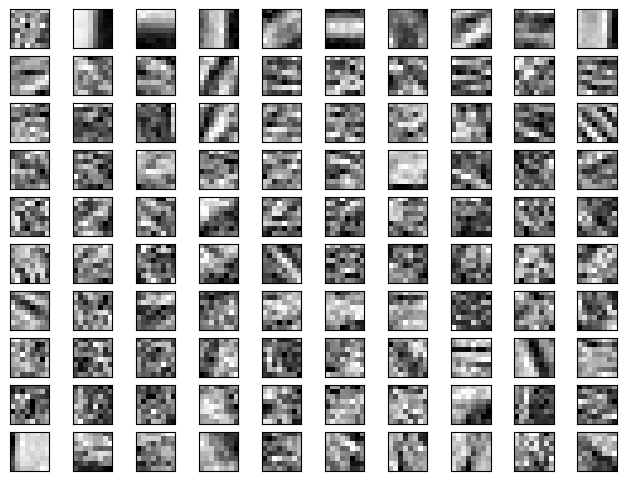

In [38]:
print(f'Component\'s Shape{comps.shape}')
plt.figure(figsize=(8, 6))
for i, comp in enumerate(comps[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())

## OPM and LARS Algorithms

Orthogonal Matching Pursuit
2 atoms...


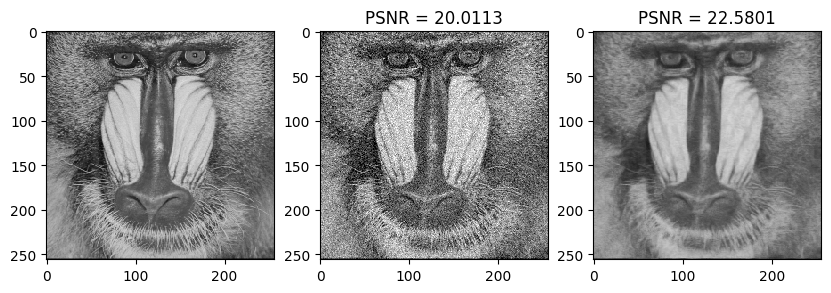

time for this algorithm = 8.451563596725464 s
Least-angle regression
2 atoms...


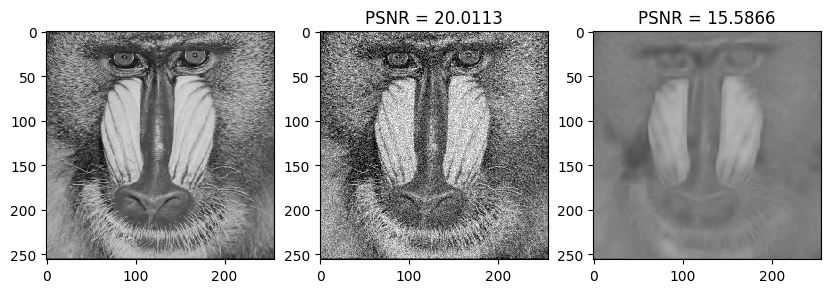

time for this algorithm = 31.976757764816284 s


In [41]:
from time import time

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n2 atoms", "lars", {"transform_n_nonzero_coefs": 2}),
]

data = extract_patches_2d(noisy_image, patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    t0 = time()
    reconstructions[title] = image.copy()

    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, comps)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)

    reconstructions[title] = reconstruct_from_patches_2d(patches, (height, width))
    show_with_diff(image, noisy_image, reconstructions[title])
    print(f'time for this algorithm = {time() - t0} s')

plt.show()